<a href="https://colab.research.google.com/github/swardy1221/fp-dm-2021/blob/main/FP_DataMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
#Mount the G Drive to access the data set
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/ner-data-mining/train.txt'
# dataset_path = 'dataset/train.txt'
dataset = []
with open(dataset_path) as fp:
  sentence = 1
  lines = fp.readlines()
  for line in lines:
    if (not line in ["\n", "\r\n"]):
      line_arr = line.split(' ')
      word = line_arr[0]
      pos = line_arr[1]
      tag = line_arr[2].strip()
      dataset.append([sentence, word, pos, tag])
    else:
      sentence += 1

In [5]:
 datasetdf = pd.DataFrame(np.array(dataset), columns=["sentence #", "word", "pos", "tag"])

In [6]:
datasetdf.head()

,sentence #,word,pos,tag
0,1,Berikut,PROPN,O
1,1,adalah,AUX,O
2,1,tujuh,NUM,O
3,1,kota,NOUN,O
4,1,di,ADP,O


In [7]:
datasetdf.shape

(30248, 4)

In [8]:
datasetdf["tag"].value_counts()

O        26728
B-PER      896
B-ORG      721
B-LOC      579
I-ORG      577
I-PER      486
I-LOC      261
Name: tag, dtype: int64

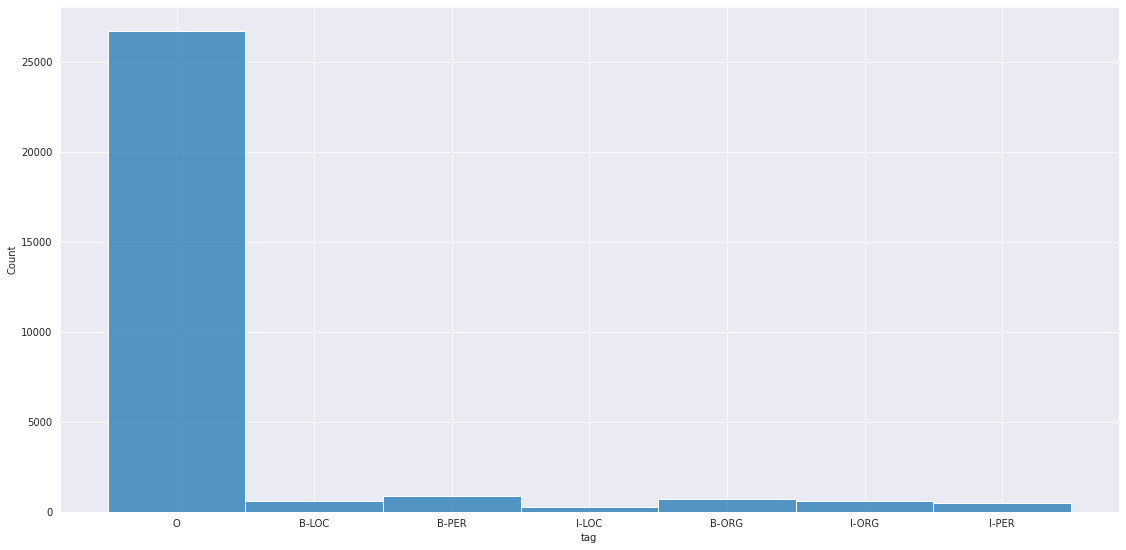

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (16,8))
sns.set_style('darkgrid')
sns.histplot(datasetdf['tag'])
plt.tight_layout(pad=2)
plt.show()

In [10]:
from itertools import chain
def get_dict_map(dataset, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(dataset['word'].to_list()))
    else:
        vocab = list(set(dataset['tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok
token2idx, idx2token = get_dict_map(datasetdf, 'token')
tag2idx, idx2tag = get_dict_map(datasetdf, 'tag')

In [11]:
datasetdf['word_idx'] = datasetdf['word'].map(token2idx)
datasetdf['tag_idx'] = datasetdf['tag'].map(tag2idx)
# dataset_fillna = datasetd.fillna(method='ffill', axis=0)
# Groupby and collect columns
dataset_group = datasetdf.groupby(['sentence #'], as_index=False)['word', 'tag', 'word_idx', 'tag_idx'].agg(lambda x: list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [12]:
import numpy as np 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def get_pad_train_test_val(dataset_grouped, dataset):

    #get max token and tag length
    n_token = len(list(set(dataset['word'].to_list())))
    n_tag = len(list(set(dataset['tag'].to_list())))

    #Pad tokens (X var)    
    tokens = dataset_grouped['word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = dataset_grouped['tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tags length:', len(train_tags),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

In [13]:
train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(dataset_group, datasetdf)
train_tags = np.array(train_tags)
val_tags = np.array(val_tags)
test_tags = np.array(test_tags)
print('train_tags: ',train_tags.shape,'val_tags: ',val_tags.shape,'test_tags: ',test_tags.shape)

train_tokens length: 987 
train_tags length: 987 
test_tokens length: 147 
test_tags: 147 
val_tokens: 330 
val_tags: 330
train_tags:  (987, 69, 7) val_tags:  (330, 69, 7) test_tags:  (147, 69, 7)


In [14]:
from sklearn.utils import class_weight

train_temp_tags = np.ravel(np.argmax(train_tags, axis=-1))
print(len(train_temp_tags))

68103


In [15]:
class_weights = class_weight.compute_class_weight(
    class_weight ='balanced', 
    classes = np.unique(train_temp_tags), 
    y = train_temp_tags
    )
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

train_label = np.argmax(train_tags, axis=-1)
print(train_tokens.shape)
print(train_label.shape)

{0: 23.845588235294116, 1: 25.074742268041238, 2: 0.14816563361405966, 3: 61.968152866242036, 4: 26.083109919571047, 5: 19.694331983805668, 6: 15.691935483870967}
(987, 69)
(987, 69)


In [16]:
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
from tensorflow.keras.utils import plot_model

In [17]:
input_dim = len(list(set(datasetdf['word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in dataset_group['word_idx'].tolist()])
n_tags = len(tag2idx)

Word2vec Model

In [18]:
# import smart_open
# smart_open.open = smart_open.smart_open
from gensim.models import Word2Vec
import os

model = Word2Vec(dataset_group['word'], size=128, window=5, min_count=3, iter=100, sg=1)

In [19]:
os.makedirs("model/w2v", exist_ok=True)
model.save("model/w2v/ner.w2v")


In [20]:
w2v = model.wv

In [21]:
w2v.index2word

[',',
 '.',
 'yang',
 'di',
 'dan',
 'dari',
 'itu',
 'untuk',
 'dengan',
 'ini',
 'dalam',
 'tidak',
 'pada',
 'akan',
 'kata',
 'juga',
 'tersebut',
 'ke',
 'ada',
 'mengatakan',
 'Indonesia',
 'telah',
 'sebagai',
 'menjadi',
 'Partai',
 'bisa',
 'tahun',
 'sudah',
 'Jakarta',
 'atau',
 'oleh',
 'Presiden',
 'adalah',
 'seperti',
 'mereka',
 'lebih',
 'karena',
 'dia',
 'kepada',
 'bahwa',
 'orang',
 'partai',
 'presiden',
 'saat',
 'politik',
 'lain',
 'persen',
 '2014',
 'negara',
 'dapat',
 'Golkar',
 'pemerintah',
 'satu',
 'Ketua',
 'harus',
 'DPR',
 '-',
 'belum',
 'Demokrat',
 'saya',
 'Jokowi',
 'kita',
 'BBM',
 'para',
 'tak',
 'Menurut',
 'baru',
 'dua',
 'melakukan',
 'katanya',
 'menyatakan',
 'calon',
 'masih',
 'masyarakat',
 'kota',
 'terjadi',
 'subsidi',
 'banyak',
 'juta',
 'beberapa',
 'bagi',
 'merupakan',
 'ujar',
 'secara',
 'Israel',
 'hanya',
 'hari',
 'pemerintahan',
 'termasuk',
 'luar',
 'baik',
 'umum',
 'Menteri',
 'saja',
 'sejumlah',
 'daerah',
 'Namun

In [22]:
w2v.similar_by_word('presiden', topn=5)

[('terpilih', 0.553078293800354),
 ('Rajasa', 0.5344081521034241),
 ('calon', 0.4960040748119354),
 ('wakil', 0.4566783010959625),
 ('bakal', 0.44886481761932373)]

In [99]:
def embedding_model():
    embedding_matrix = np.zeros((len(datasetdf['word']), output_dim))
    for i,w in enumerate(datasetdf['word']):
        try:
            embedding_matrix[i] = w2v.wv[w]
        except:
            continue

    embedding_layer = Embedding(
            input_dim = embedding_matrix.shape[0],
            weights = [embedding_matrix],
            output_dim = output_dim,
            input_length = input_length,
            trainable = False
    )
    return embedding_layer

In [94]:
print(input_dim)
print(output_dim)
print(input_length)

6630
64
69


In [100]:
def get_bilstm_lstm_model(embedding_pre=None):
    model = Sequential()
    if embedding_pre is None:
        model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    elif embedding_pre == 'w2v':
        model.add(embedding_model())
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add((Dense(n_tags, activation="softmax")))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [101]:
maj_index = tag2idx['O']

''' Change it More for Better Fine-Tuning '''

class_weight_dict[maj_index] = 28.5277954105731576 
print(class_weight_dict)
sample_weights = np.ones(shape=(len(train_label), train_label.shape[-1]))
for i in range(17):
    sample_weights[train_label == i] = class_weight_dict.get(i)
print(sample_weights.shape)

{0: 23.845588235294116, 1: 25.074742268041238, 2: 28.52779541057316, 3: 61.968152866242036, 4: 26.083109919571047, 5: 19.694331983805668, 6: 15.691935483870967}
(987, 69)


In [102]:
import tensorflow as tf
nlp_model = get_bilstm_lstm_model('w2v')
plot_model(nlp_model)
his = nlp_model.fit(train_tokens, train_label , batch_size = 64, epochs=5, validation_split=0.2, sample_weight = sample_weights) 
tf.keras.models.save_model(nlp_model, filepath  = "/content/drive/MyDrive/Colab Notebooks/ner-data-mining/bilstm_withoutW.h5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 69, 64)            1935872   
                                                                 
 bidirectional_5 (Bidirectio  (None, 69, 128)          66048     
 nal)                                                            
                                                                 
 lstm_11 (LSTM)              (None, 69, 64)            49408     
                                                                 
 dense_5 (Dense)             (None, 69, 7)             455       
                                                                 
Total params: 2,051,783
Trainable params: 115,911
Non-trainable params: 1,935,872
_________________________________________________________________
Epoch 1/5
13/13 [==============================] - 12s 414ms/step - loss: 44.1193 - accuracy: 0.8862 - 

In [ ]:
nlp_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ner-data-mining/bilstm_withoutW.h5')

y_test = np.argmax(test_tags, axis=-1)
print(test_tokens.shape,y_test.shape)
nlp_model.evaluate(test_tokens, y_test)

(147, 69) (147, 69)
5/5 [==============================] - 1s 44ms/step - loss: 0.1582 - accuracy: 0.9718


[0.15816736221313477, 0.9718031883239746]

In [ ]:
def predict(seed):
    query  = test_tokens[seed]
    query_text = []
    for i in query.tolist():
        query_text.append(idx2token.get(i))
    print('Query_Text: ',' '.join(query_text[:10]))

    ans = y_test[seed]
    ans_text = []
    for i in ans.tolist():
        ans_text.append(idx2tag.get(i))
    print('Tag_Text: ',' '.join(ans_text[:10]))

    query = query.reshape(1,-1)
    pred = nlp_model.predict(query)
    pred = np.ravel(np.argmax(pred, axis=-1))
    print('Query: ',query.shape,'Prediction: ',pred.shape)

    pred_list = []
    for i in pred.tolist():
        pred_list.append(idx2tag.get(i))
    print('Prediction_Text: ',' '.join(pred_list[:10])) 
    print()
    print('--- Better-Representation---')
    print()
    rep_qr = []
    for q, r_tag in zip(query_text[:10], ans_text[:10]):
        rep_qr.append(q)
        rep_qr.append('['+r_tag+']')
    print('Actual_NER: ',' '.join(rep_qr),'....')
    print()
    rep_qp = []
    for q, r_tag in zip(query_text[:10], pred_list[:10]):
        rep_qp.append(q)
        rep_qp.append('['+r_tag+']')
    print('--'*70)
    print()
    print('Predicted_NER: ',' '.join(rep_qp),'....')

In [ ]:
predict(["Seorang prajurit TNI meluncurkan rudal ke wilayah Timor Timur dan menyebabkan ribuan korban jiwa pada Tahun 1999"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


IndexError: ignored